In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import copy
from scipy.optimize import curve_fit
import math


In [2]:
sys.path.append("FlowMater")
sys.path.append("IonLib/")

from dataframe_parse import add_unique_IDs

In [3]:
#data load
df_path="temp/df.bin"
df=joblib.load(df_path)

fp_keys=joblib.load("temp/all_fp_keys.bin")
anal_df=add_unique_IDs(df,fp_keys)

IonLib/dataframe_parse.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anal_df["Anneal"][anal_df["Anneal"] >= 1] = 1


In [4]:
processed_df=copy.copy(anal_df)

In [5]:
#list(processed_df.columns)

In [6]:
check_list=["1st Day (unix)","Formal donor ratio","Formal acceptor ratio","Formal salt ratio","Donor MW"]

processed_df["unique_id"]=""

for col in check_list:
    processed_df["unique_id"]=processed_df["unique_id"]+"-"+processed_df[col].astype(str)
    
#"Day1_unix"]+diff_records["Formal donor ratio"]+diff_records["Formal acceptor ratio"]+diff_records["Formal salt ratio"]

In [7]:
unique_ids=list(set(list(processed_df["unique_id"])))
#unique_ids=list(set(list(processed_df["manual condition"])))

In [8]:

temperature_label="Temperature of $\sigma$$_\mathrm{ion}$ ($^\mathrm{o}$C)"
y_label="Log ionic conductivity (S/cm)"

In [9]:
def vtf_func(t,*params):
    
    #gaussian
    sig0=params[0]
    B=params[1]
    TK=params[2]
    y=sig0+(B/(t-TK))
    return y

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.major.size"] = 10              
plt.rcParams["ytick.major.size"] = 10            

#analyze parameters vy VTF equation
def VTF_fit(temperature_df,fit_start=0,fit_end=np.inf,opt=None,ax=None):

    temperature_df=temperature_df.sort_values(by=temperature_label)
    t=np.array(temperature_df[temperature_label])+273.15
    x=1/t
    logy=np.array(temperature_df[y_label])
    y=logy*2.303

    guess=[-3,300,0]
    bounds=[(-np.inf,-np.inf,-np.inf,),
          (np.inf,np.inf,np.inf)]

    popt, pcov = curve_fit(vtf_func, t[fit_start:fit_end], y[fit_start:fit_end], p0=guess,bounds=bounds)
        
    pred_y=vtf_func(t,*popt)
    sig0=popt[0]/2.303
    B=-popt[1]
    TK=popt[2]
    
    y=y/2.303
    pred_y=pred_y/2.303
    
    err=np.mean(abs(pred_y-y[fit_start:fit_end]))
        
    #delete inappropriate fitting results
    fail_flag=False
    
    if err>0.06:
        fail_flag=True
    
    
    if B>10000:
        fail_flag=True
    if sig0<-20:
        fail_flag=True
    if TK>250 or TK<0:
        fail_flag=True
    
    
    #plt.figure(figsize=(4,4))
    ax.scatter(1000/t,y,label="exp")
    
    if fail_flag:
        color="r"
    else:
        color="b"
        
    ax.plot(1000/t,pred_y,alpha=0.5,label="fit",color=color)
    #plt.xlabel("1000/$T$ (K$^{-1}$)")
    #plt.ylabel("Log $\sigma$$_\mathrm{ion}$ (S/cm)")
    ratio=temperature_df["Salt weight ratio"][0]
    acc=temperature_df["acceptor_amount_compound name"][0]
    salt=temperature_df["salt_amount_compound name"][0]
    electrolyte_name=temperature_df["manual condition"][0]
    #title=f"{electrolyte_name} : fit success?: {not fail_flag} MAE: {err} TK {TK}"
    title=electrolyte_name+" ($T_\mathrm{K}$:" + f"{round(TK)})"
    
    plt.title(title)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)    

    xmin=np.round(min(1000*x),1)
    xmax=np.round(max(1000*x),1)
    plt.xticks(np.arange(xmin, xmax, step=0.2))
    

    temp_dict={}
    temp_dict["Ion VTF: log $\sigma_{0}$ (S/cm)"]=sig0
    temp_dict["Ion VTF: $B$ (J/mol)"]=B*8.31
    temp_dict["Ion VTF: $T_\mathrm{K}$ ($^\mathrm{o}$C)"]=TK-273.15      
        

    if fail_flag:
        return False
    else:
        return temp_dict
    


def auto_fit(fit_func,exceptional_dict):
    res_dict={}

    parameter_numbers=len(unique_ids)
    fig = plt.figure(figsize=(18,parameter_numbers*2))
    max_cols=3
    max_rows=math.ceil(parameter_numbers/max_cols)

    cnt=1
    for i,electrolyte_id in enumerate(unique_ids):
        #check for each uniqueelectrolyte
        sel_df=processed_df[processed_df["unique_id"]==electrolyte_id]

        #check if temperature dependence was measured
        if set(sel_df[temperature_label])!={25.01}:
            
            ax = fig.add_subplot(max_rows,max_cols,cnt)
            
            print(electrolyte_id)
            print(sel_df.index[-1])

            opt=None
            if electrolyte_id in exceptional_dict:
                temp=exceptional_dict[electrolyte_id]
                fit_start=temp[0]
                fit_end=temp[1]
                
                try:
                    opt=temp[2]
                except:
                    opt=None
            else:
                fit_start=0
                fit_end=10**6

            temperature_df=sel_df[sel_df[temperature_label]!=25.01]
            temperature_df=temperature_df[temperature_df[temperature_label]==temperature_df[temperature_label]]
            
            if temperature_df.shape[0]<2:
                continue
            
            
            try:
                temp_dict=fit_func(temperature_df,fit_start,fit_end,opt=opt,ax=ax)
            except:
                return temperature_df
            
            if temp_dict:
                ind=sel_df.index
                for i in ind:
                    res_dict[i]=temp_dict
            print(temp_dict)
            cnt+=1

            #break
    return res_dict
    
    

-1637074800.0-0.4954192217990498-0.32649488442536945-0.17808589377558065-120.15
normal_experiment79_graph_integrated_json_3_database/experiments/MU/nmr/1209/no2_ppo_chloranil_lifsi/nmr.graphml
False
-1630940400.0-0.7861362687647733-0.19513255104950208-0.018731180185724724-120.15
normal_experiment58_database/experiments/MU/dsc/916_dsc/907/dsc.graphml
False
-1637506800.0-0.47503304943717223-0.3123985321385005-0.2125684184243273-120.15
normal_experiment81_graph_integrated_json_5_database/experiments/MU/nmr/1209/no4_ppo_chloranil_libf4/nmr.graphml
False
-1625670000.0-0.7225247802099511-0.1576918511419941-0.11978336864805475-120.15
normal_experiment67_graph_integrated_json_7_database/experiments/MU/eis_temperature_dependence/724/eis_temp.graphml
False
-1630767600.0-0.5454078307391687-0.3615400887518544-0.09305208050897688-120.15
normal_experiment107_graph_integrated_json_1_database/experiments/MU/normal/1014(905)_ppo_chloranil_liftfsi/1014.graphml
{'Ion VTF: log $\\sigma_{0}$ (S/cm)': -3.56

/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/ipykernel/__main__.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-1633100400.0-0.6079952047190932-0.15189611836428868-0.24010867691661802-120.15
normal_experiment97_graph_integrated_json_0_database/experiments/MU/normal/1004(1002)_ppo_bq_liftfsi/1004.graphml
{'Ion VTF: log $\\sigma_{0}$ (S/cm)': -2.951089131932171, 'Ion VTF: $B$ (J/mol)': 3368.129900844394, 'Ion VTF: $T_\\mathrm{K}$ ($^\\mathrm{o}$C)': -71.45734089086042}


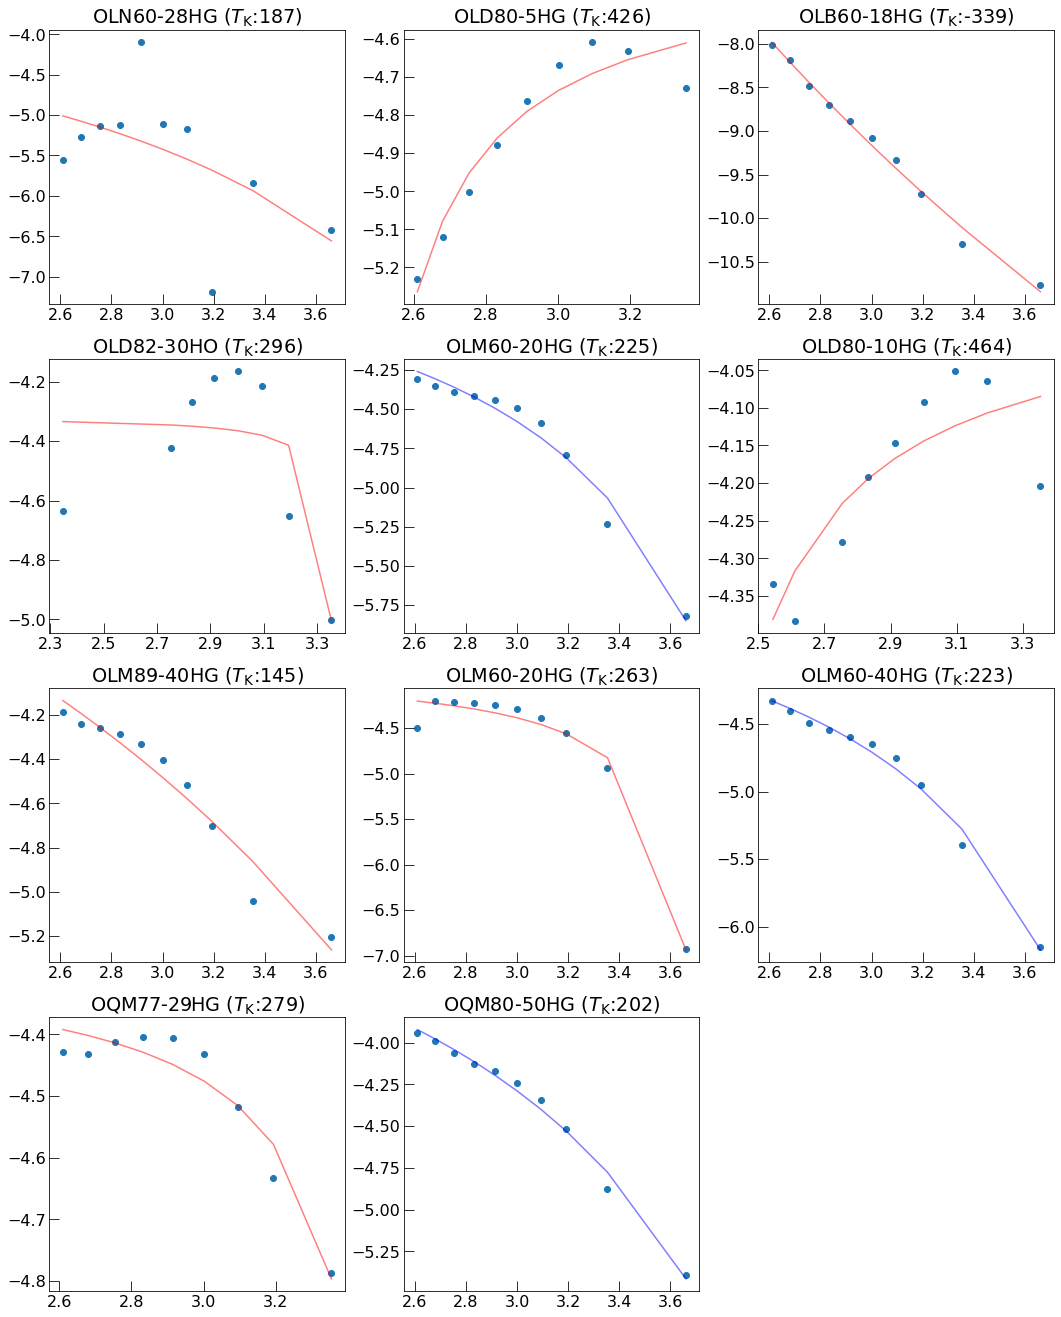

In [10]:
exceptional_dict={}
VTF_dict=auto_fit(VTF_fit,exceptional_dict)

In [11]:
joblib.dump(VTF_dict,"temp/parsed/vtf_anal.bin")


['temp/parsed/vtf_anal.bin']

In [12]:
VTF_dict

{'normal_experiment166_graph_integrated_json_2_database/experiments/MU/normal/905_ppo_chloranil_liftfsi/80/905_80.graphml': {'Ion VTF: log $\\sigma_{0}$ (S/cm)': -3.565960461603268,
  'Ion VTF: $B$ (J/mol)': 2094.423255811613,
  'Ion VTF: $T_\\mathrm{K}$ ($^\\mathrm{o}$C)': -47.91856013728136},
 'normal_experiment166_graph_integrated_json_0_database/experiments/MU/normal/905_ppo_chloranil_liftfsi/80/905_80.graphml': {'Ion VTF: log $\\sigma_{0}$ (S/cm)': -3.565960461603268,
  'Ion VTF: $B$ (J/mol)': 2094.423255811613,
  'Ion VTF: $T_\\mathrm{K}$ ($^\\mathrm{o}$C)': -47.91856013728136},
 'normal_experiment166_graph_integrated_json_1_database/experiments/MU/normal/905_ppo_chloranil_liftfsi/80/905_80.graphml': {'Ion VTF: log $\\sigma_{0}$ (S/cm)': -3.565960461603268,
  'Ion VTF: $B$ (J/mol)': 2094.423255811613,
  'Ion VTF: $T_\\mathrm{K}$ ($^\\mathrm{o}$C)': -47.91856013728136},
 'normal_experiment62_graph_integrated_json_5_database/experiments/MU/eis_temperature_dependence/1110(0905)eis/e